# 🎨🖌️ Synthetic Data Generation

The third dataset is generated using Google's Imagen v3. Canvases and objects are created separately and then combined so bounding boxes can be generated.

Number of images:
- `Training = 20264 / 4 = 5066`
- `Validation = 4304 / 4 = 1076`

Test data will reuse the original data set for comparison.

In [15]:
from google import genai
from PIL import Image
from PIL import ImageFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from io import BytesIO
from dotenv import load_dotenv
from IPython.display import display
import cv2

from src import utils

In [2]:
# Load the Google API key from the .env file
load_dotenv("src\\secrets.env")
GAPI_KEY = os.getenv("GAPI")

In [3]:
# Connect to the Google GenAI API
client = genai.Client(api_key=GAPI_KEY)

## 1. Canvas Images

Canvas images are generated using a randomized prompt for the Google Imagen v3 generative model. Each image is unique, so they are generated individually for both the training and validation sets. This also emphasizes the strength of the gen-ai approach where each image can be truly unique compared to sampling from background canvases in other techniques.

In [18]:
# List of terrain types
terrain_types = [
    "a forest",
    "a desert",
    "a mountain",
    "a beach",
    "an urban",
    "a countryside",
    "a swamp",
    "a tundra",
    "a jungle",
    "a savanna",
    "an oceanside"
]

In [19]:
# List of times of day
time_of_day = [
    "sunrise",
    "early morning",
    "late morning",
    "midday",
    "early afternoon",
    "late afternoon",
    "sunset",
    "early evening",
    "late evening",
    "dusk",
    "night"
]

In [20]:
# List of conditions
conditions = [
    "sunny",
    "cloudy",
    "rainy",
    "stormy",
    "foggy",
    "snowy",
    "windy",
    "clear"
]

In [21]:
# List of seasons
seasons = [
    "spring",
    "summer",
    "autumn",
    "winter"
]

In [7]:
# Example prompt
example_prompt = utils.synth.canvas_prompt(terrain_types, time_of_day, conditions, seasons, seed = 0)
print("Example prompt:\n", example_prompt)

Example prompt:
 A photo of a savanna landscape in summer at evening with foggy weather taken by a professional photographer.


In [9]:
# Example image from the example prompt
example_image = utils.synth.canvas_genai(client, example_prompt, 1)

In [ ]:
# Convert byte string object to PIL image
img = Image.open(BytesIO(example_image[0].image.image_bytes))

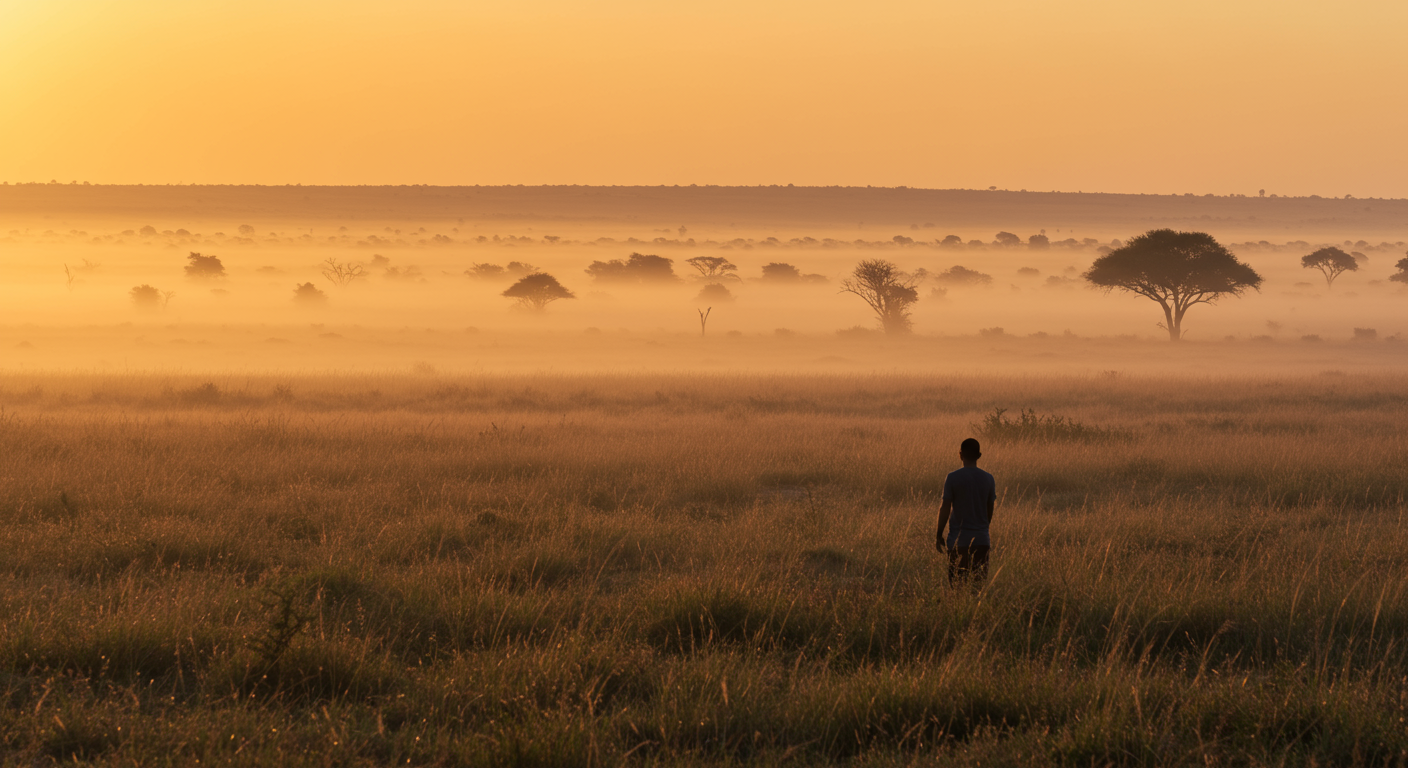

In [15]:
# Display PIL image
display(img)

### a. Training Data

Training data is generated in the same way as described above. Imagen returns a maximum of 4 images per prompt which is used to minimize delays due to response limits.

In [ ]:
# Set the number of training data images to create
training_total = 5066  # Actual = 5066

In [23]:
# Set the data directory
train_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "genai_data", "train")

# Create the folders if they don't exist
os.makedirs(train_data_dir, exist_ok=True)

In [24]:
while training_total > 0:
    
    # Create a seed for reproducibility
    seed = training_total * 100
    
    # Create a random prompt
    prompt = utils.synth.canvas_prompt(terrain_types, time_of_day, conditions, seasons, seed=seed)

    # Determine how to many images to generate (1 to 4)
    if training_total >= 4:
        num_images = 4
    else:
        num_images = training_total

    # Generate images from the prompt
    images = utils.synth.canvas_genai(client, prompt, num_images)
    
    # Loop through the returned images
    for image in images:
        
        # Base filename
        base_filename = f"genai_img_{training_total:05d}"
        
        # Get the image bytes and save as PNG
        img_bytes = image.image.image_bytes
        img = Image.open(BytesIO(img_bytes))
        img.save(os.path.join(train_data_dir, f"{base_filename}.png"))
        
        # Decrement the training total
        training_total -= 1

    # Pause to avoid rate limits
    # Imagen model allows 20 requests per minute, so 1 request every 3 seconds
    # pausing for 3 seconds plus code execution time should be sufficient
    # total execution time expected to be around 4 seconds * 5066 = 20264 seconds = 5.63 hours
    # divided by 4 images per request = 1.41 hours
    time.sleep(3)

### b. Validation Data

Validation images are generated similarly to the training images.

In [22]:
# Set the number of validation data images to create
validation_total = 1076  # Actual = 1076

In [23]:
# Set the data directory
val_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "genai_data", "val")

# Create the folders if they don't exist
os.makedirs(val_data_dir, exist_ok=True)

In [24]:
while validation_total > 0:
    
    # Create a seed for reproducibility
    seed = validation_total * 1000
    
    # Create a random prompt
    prompt = utils.synth.canvas_prompt(terrain_types, time_of_day, conditions, seasons, seed=seed)

    # Determine how to many images to generate (1 to 4)
    if validation_total >= 4:
        num_images = 4
    else:
        num_images = validation_total

    # Generate images from the prompt
    images = utils.synth.canvas_genai(client, prompt, num_images)
    
    # Loop through the returned images
    for image in images:
        
        # Base filename
        base_filename = f"genai_img_v_{validation_total:05d}"
        
        # Get the image bytes and save as PNG
        img_bytes = image.image.image_bytes
        img = Image.open(BytesIO(img_bytes))
        img.save(os.path.join(val_data_dir, f"{base_filename}.png"))
        
        # Decrement the validation total
        validation_total -= 1

    # Pause to avoid rate limits
    # Imagen model allows 20 requests per minute, so 1 request every 3 seconds

    time.sleep(3)

## 2. Objects

Object generation follows a similar process but has additional steps to isolate the object from its background color, apply transparency, and crop to the minimal bounding box. The process is demonstrated below and then applied to each canvas image in the trainind and validation data sets.

In [4]:
# Create a list of object types
object_types = [
    "quadcopter",
    "fixed-wing",
    "hexacopter",
    "first-person view (FPV)",
    "military-style"
]

In [5]:
# Create a list of object colors
object_colors = [
    "camouflage",
    "blue",
    "gray",
    "yellow",
    "orange",
    "purple",
    "white",
    "black"
]

In [6]:
# Create a list of maneuvers
object_maneuvers = [
    "hovering",
    "ascending",
    "diving",
    "banking left",
    "banking right",
    "moving forward",
    "rolling",
    "falling"
]

In [7]:
# Example object prompt
example_object_prompt = utils.synth.object_prompt(object_types, object_colors, object_maneuvers, seed=0)
print("Example object prompt:\n", example_object_prompt)

Example object prompt:
 A photo of a single, purple colored military-style drone banking right through the air against a seamless, solid green background.


In [8]:
# Example image from the example object prompt
example_object_image = utils.synth.object_genai(client, example_object_prompt, 1)

In [9]:
# Convert byte string object to PIL image
img = Image.open(BytesIO(example_object_image[0].image.image_bytes))

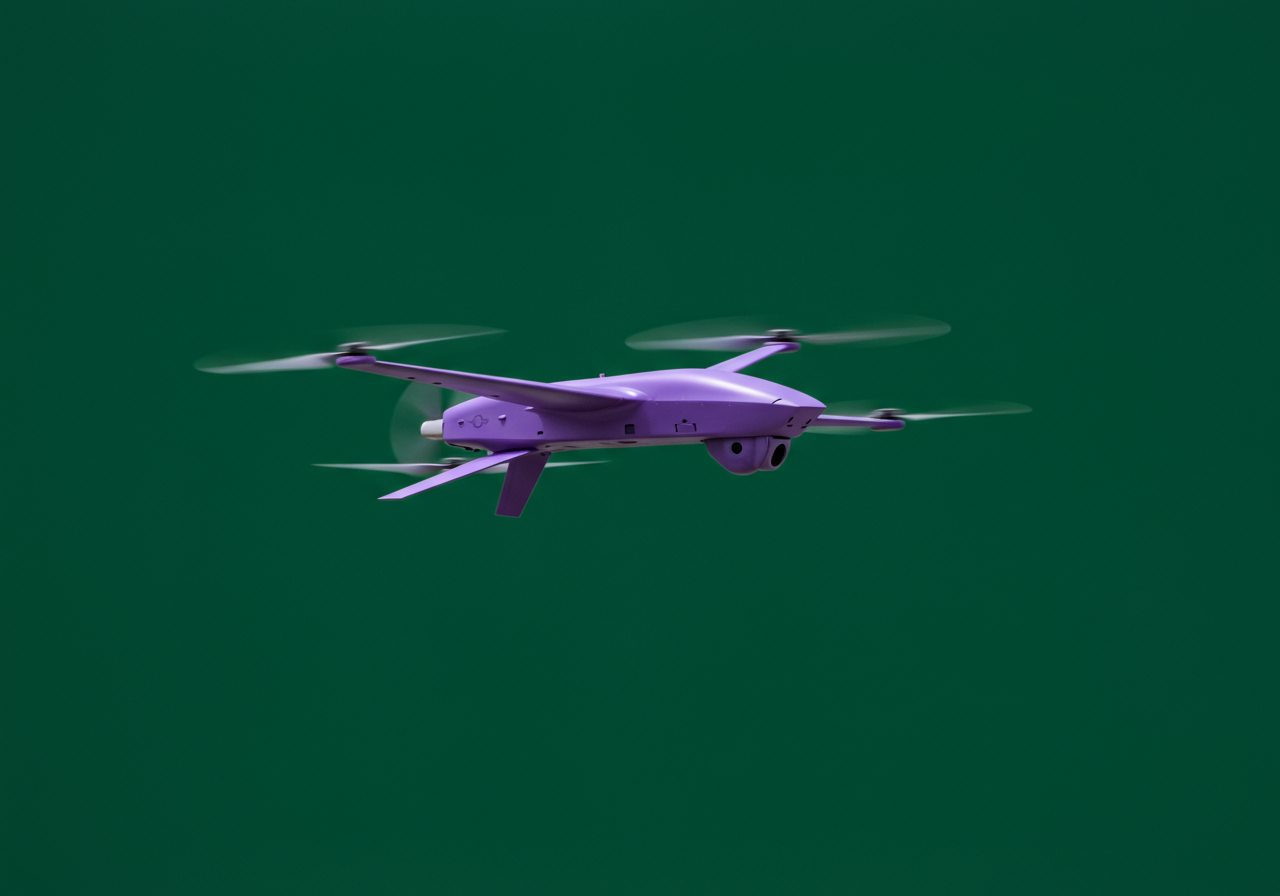

In [10]:
# Display PIL image
display(img)

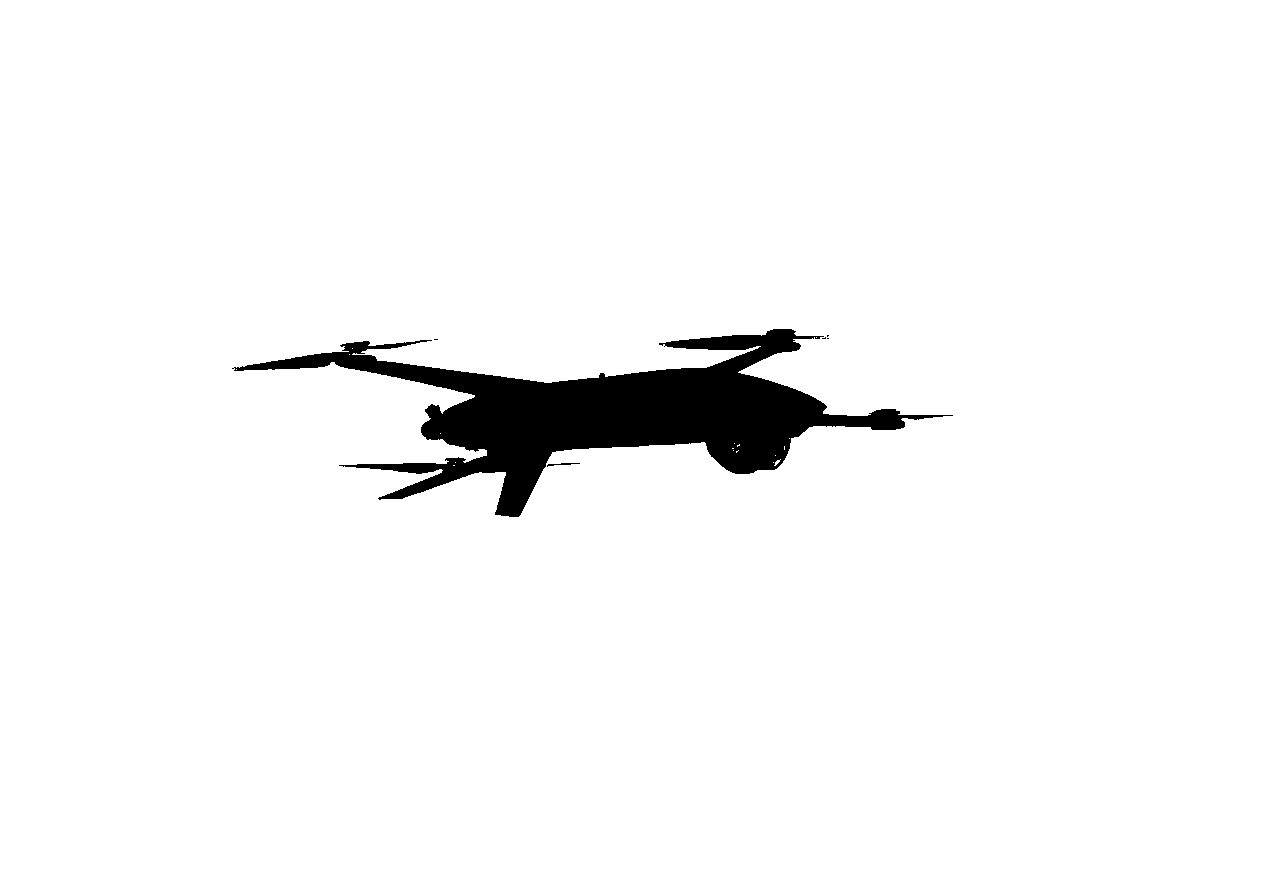

In [11]:
# Generate a mask for the image to isolate the object
obj_mask = utils.synth.object_mask(img)
display(obj_mask)

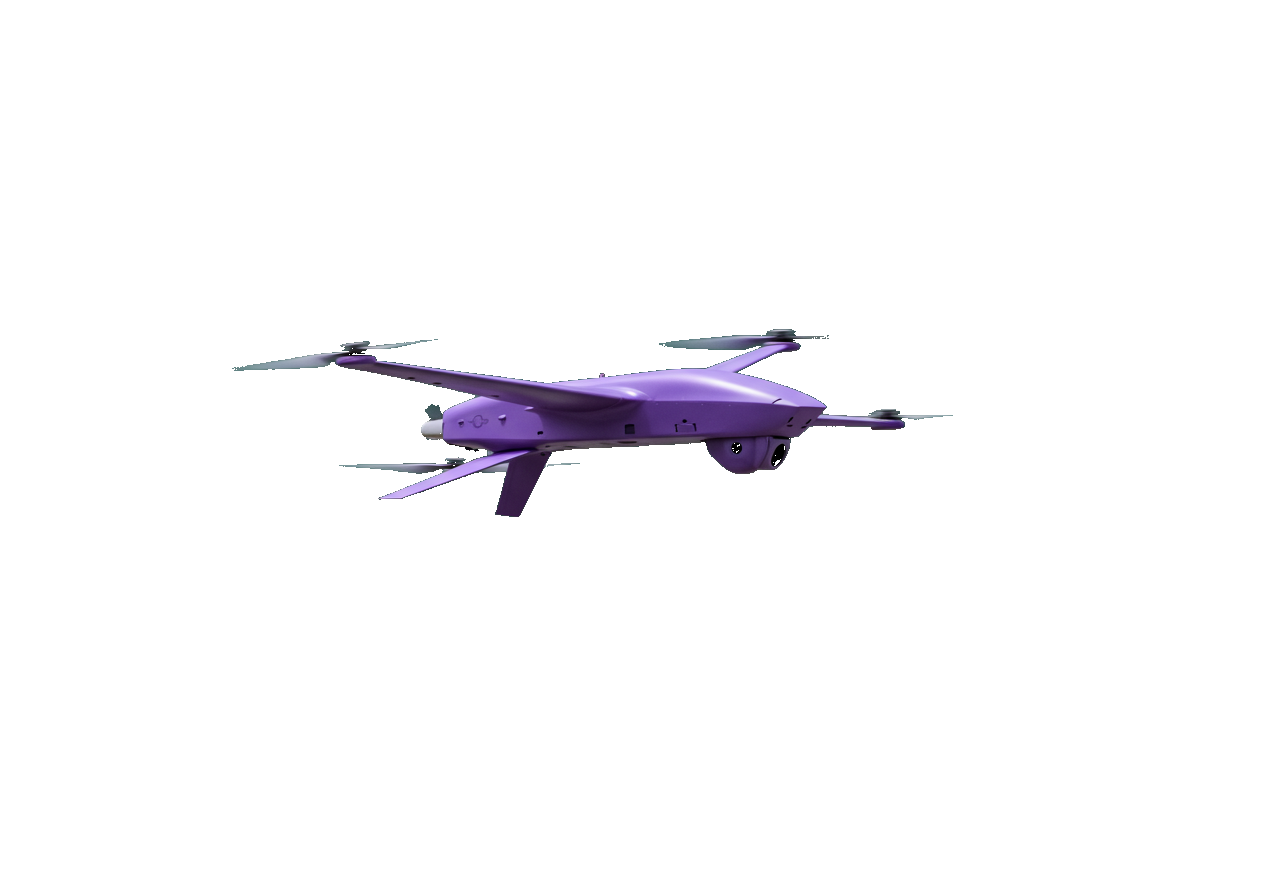

In [12]:
# Apply the object mask to generate transparent background
obj_img = utils.synth.object_alpha(img, obj_mask)
display(obj_img)

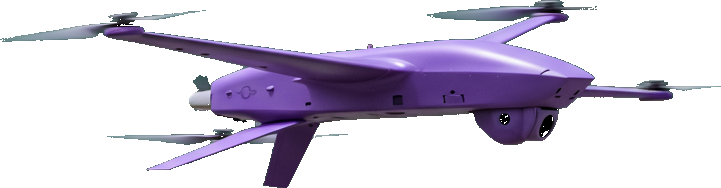

In [13]:
# Crop the image down to it's minimal bounding box
obj_img = utils.synth.object_crop(obj_img)
display(obj_img)

## 3. Data Generation

### a. Training Data

In [28]:
# Get the list of training canvas images
trn_canvas_images = utils.files.get_image_files(os.path.join(utils.INTERIM_DATA_DIR, "genai_data", "train"))

print(f"Number of training canvas images: {len(trn_canvas_images)}")

Number of training canvas images: 5066


In [ ]:
# Adjusting the starting index due to interrupted generation run
trn_canvas_images = trn_canvas_images[4482:]
print(trn_canvas_images[0])

data\interim\genai_data\train\genai_img_04483.png


In [30]:
# Set a random seed for reproducibility
rng = np.random.default_rng(4444)

# Loop through each training canvas image
for i, canvas_image_path in enumerate(trn_canvas_images):
    # Object seed for reproducibility
    base_seed = (i + 1) * 10000
    
    # Remove the file extension for the base filename
    base_filename = os.path.splitext(canvas_image_path)[0]
    
    # Load the canvas image
    canvas_img = Image.open(canvas_image_path)
    canvas_size = canvas_img.size
    
    # Loop to create between 1 and 4 objects per canvas image
    num_objects = rng.integers(1, 5)
    
    for n in range(num_objects):
        # Create a random object prompt
        obj_seed = base_seed + (n + 1) * 100
        obj_prompt = utils.synth.object_prompt(object_types, object_colors, object_maneuvers, seed=obj_seed)

        # Generate the object image
        obj_images = utils.synth.object_genai(client, obj_prompt, 1)
        
        # Convert byte string object to PIL image
        obj_img = Image.open(BytesIO(obj_images[0].image.image_bytes))
        
        # Generate a mask for the image to isolate the object
        obj_mask = utils.synth.object_mask(obj_img)
        
        # Apply the object mask to generate transparent background
        obj_img = utils.synth.object_alpha(obj_img, obj_mask)
        
        # Crop the image down to it's minimal bounding box
        obj_img = utils.synth.object_crop(obj_img)
        
        # Apply gaussian blur to the object
        obj_img = obj_img.filter(ImageFilter.GaussianBlur(2))
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=obj_seed)
        obj_img = utils.synth.scale_obj(obj_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = obj_img.size[0] / canvas_size[0]
        obj_height = obj_img.size[1] / canvas_size[1]

        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(obj_img.size, canvas_size, seed=obj_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + obj_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + obj_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas_img.paste(obj_img, coordinates_topleft, obj_img)

        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(f"{base_filename}.txt", "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")

    # Save the final image
    canvas_img.save(canvas_image_path)
    
    # Wait to avoid rate limits
    time.sleep(6)  # 20 requests per minute for Imagen model, so 1 request every 3 seconds, each loop makes 1-4 requests

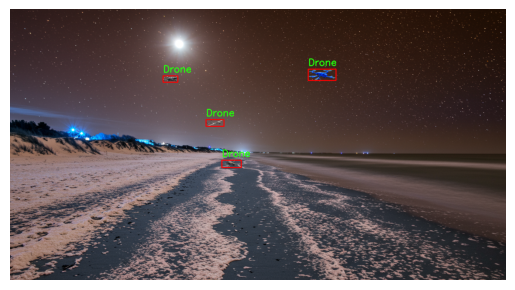

In [229]:
# Check bounding boxes
trn_imgs = utils.files.get_image_files(train_data_dir)
ann_files = utils.files.get_annotation_files(train_data_dir)

random_img = rng.integers(low=0, high=len(trn_imgs))
trn_img = trn_imgs[random_img]
ann_file = ann_files[random_img]

bboxes = utils.label_data.read_bbox_file(ann_file)

xxyy_bboxes = []
for bbox in bboxes:
    xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
    xxyy_bboxes.append(xxyy_bbox)

bbox_img = utils.image_data.draw_bbox(trn_img, xxyy_bboxes)

plt.imshow(bbox_img)
plt.axis('off')
plt.show()

In [230]:
# Multiscale data destination directory
multiscale_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "genai_data", "multiscale")
os.makedirs(multiscale_data_dir, exist_ok=True)

In [231]:
# Create the training data directory
ms_train_data_dir = os.path.join(multiscale_data_dir, "train")
os.makedirs(ms_train_data_dir, exist_ok=True)

In [232]:
# Get the list of images and annotations in the training data directory
train_images = utils.files.get_image_files(train_data_dir)
train_annotations = utils.files.get_annotation_files(train_data_dir)
print("There are {} training images and {} training annotations.".format(len(train_images), len(train_annotations)))

There are 5066 training images and 5066 training annotations.


In [233]:
# Ensure all file names match in order
for img, ann in zip(train_images, train_annotations):
    img_base = os.path.splitext(os.path.basename(img))[0]
    ann_base = os.path.splitext(os.path.basename(ann))[0]
    if img_base != ann_base:
        print(f"Mismatch found: Image {img_base} and Annotation {ann_base}")
        # Check if the annotation file exists
        if not os.path.exists(ann):
            print(f"Annotation file {ann} does not exist.")
        else:
            print(f"Annotation file {ann} exists.")
        break
print("No mismatches found between training images and annotations.")

No mismatches found between training images and annotations.


In [234]:
# Create a dictionary for quadrant aliases for final file names
quadrant_alias = {
    "top_left": "00",
    "top_right": "01",
    "bottom_left": "10",
    "bottom_right": "11"
}

In [235]:
# Split the training images and annotations into 4 quadrants with a 5% overlap

for img, ann in zip(train_images, train_annotations):
    # Get the base file name without extension for final file names
    base_name = os.path.splitext(os.path.basename(img))[0]

    # Read the image
    image = cv2.imread(img)
    if image is None:
        print(f"Failed to read image {img}")
        continue
    # Get the base image dimensions
    base_height = image.shape[0]
    base_width = image.shape[1]

    # Split the image into 4 quadrants
    img_quadrants = utils.image_data.image_quadrants(img)
    
    # Split the annotation into 4 quadrants
    ann_bboxes = utils.label_data.read_bbox_file(ann)
    ann_quadrants = utils.label_data.bbox_quadrants(ann_bboxes)

    # Process each quadrant
    for quad_name, img_quad in img_quadrants.items():
        ann_quad = ann_quadrants.get(quad_name, [])
        # Save the quadrant image and its annotations
        cv2.imwrite(os.path.join(ms_train_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.png"), img_quad)
        with open(os.path.join(ms_train_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.txt"), 'w') as f:
            for bbox in ann_quad:
                obj, x_c, y_c, w, h = utils.label_data.bbox_yolo(bbox)
                line = f"{obj} {x_c} {y_c} {w} {h}\n"
                f.write(line)

### b. Validation Data

In [226]:
# Get the list of validation canvas images
val_canvas_images = utils.files.get_image_files(os.path.join(utils.INTERIM_DATA_DIR, "genai_data", "val"))

print(f"Number of validation canvas images: {len(val_canvas_images)}")

Number of validation canvas images: 1076


In [227]:
# Adjusting the starting index due to interrupted generation run
val_canvas_images = val_canvas_images[1064:]
print(val_canvas_images[0])

data\interim\genai_data\val\genai_img_v_01065.png


In [228]:
# Set a random seed for reproducibility
rng = np.random.default_rng(55555)

# Loop through each validation canvas image
for i, canvas_image_path in enumerate(val_canvas_images):
    # Object seed for reproducibility
    base_seed = (i + 6750) * 100000
    
    # Remove the file extension for the base filename
    base_filename = os.path.splitext(canvas_image_path)[0]
    
    # Load the canvas image
    canvas_img = Image.open(canvas_image_path)
    canvas_size = canvas_img.size
    
    # Loop to create between 1 and 4 objects per canvas image
    num_objects = rng.integers(1, 5)
    
    for n in range(num_objects):
        # Create a random object prompt
        obj_seed = base_seed + (n + 1) * 100
        obj_prompt = utils.synth.object_prompt(object_types, object_colors, object_maneuvers, seed=obj_seed)

        # Generate the object image
        obj_images = utils.synth.object_genai(client, obj_prompt, 1)
        
        # Convert byte string object to PIL image
        obj_img = Image.open(BytesIO(obj_images[0].image.image_bytes))
        
        # Generate a mask for the image to isolate the object
        obj_mask = utils.synth.object_mask(obj_img)
        
        # Apply the object mask to generate transparent background
        obj_img = utils.synth.object_alpha(obj_img, obj_mask)
        
        # Crop the image down to it's minimal bounding box
        obj_img = utils.synth.object_crop(obj_img)
        
        # Apply gaussian blur to the object
        obj_img = obj_img.filter(ImageFilter.GaussianBlur(2))
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=obj_seed)
        obj_img = utils.synth.scale_obj(obj_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = obj_img.size[0] / canvas_size[0]
        obj_height = obj_img.size[1] / canvas_size[1]

        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(obj_img.size, canvas_size, seed=obj_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + obj_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + obj_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas_img.paste(obj_img, coordinates_topleft, obj_img)

        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(f"{base_filename}.txt", "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")

    # Save the final image
    canvas_img.save(canvas_image_path)
    
    # Wait to avoid rate limits
    time.sleep(6)  # 20 requests per minute for Imagen model, so 1 request every 3 seconds, each loop makes 1-4 requests

In [236]:
# Multiscale data destination directory
multiscale_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "genai_data", "multiscale")
os.makedirs(multiscale_data_dir, exist_ok=True)

In [237]:
# Create the validation data directory
ms_val_data_dir = os.path.join(multiscale_data_dir, "val")
os.makedirs(ms_val_data_dir, exist_ok=True)

In [239]:
# Get the list of images and annotations in the validation data directory
val_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "genai_data", "val")
val_images = utils.files.get_image_files(val_data_dir)
val_annotations = utils.files.get_annotation_files(val_data_dir)
print("There are {} validation images and {} validation annotations.".format(len(val_images), len(val_annotations)))

There are 1076 validation images and 1076 validation annotations.


In [240]:
# Ensure all file names match in order
for img, ann in zip(val_images, val_annotations):
    img_base = os.path.splitext(os.path.basename(img))[0]
    ann_base = os.path.splitext(os.path.basename(ann))[0]
    if img_base != ann_base:
        print(f"Mismatch found: Image {img_base} and Annotation {ann_base}")
        # Check if the annotation file exists
        if not os.path.exists(ann):
            print(f"Annotation file {ann} does not exist.")
        else:
            print(f"Annotation file {ann} exists.")
        break
print("No mismatches found between validation images and annotations.")

No mismatches found between validation images and annotations.


In [241]:
# Create a dictionary for quadrant aliases for final file names
quadrant_alias = {
    "top_left": "00",
    "top_right": "01",
    "bottom_left": "10",
    "bottom_right": "11"
}

In [242]:
# Split the validation images and annotations into 4 quadrants with a 5% overlap

for img, ann in zip(val_images, val_annotations):
    # Get the base file name without extension for final file names
    base_name = os.path.splitext(os.path.basename(img))[0]

    # Read the image
    image = cv2.imread(img)
    if image is None:
        print(f"Failed to read image {img}")
        continue
    # Get the base image dimensions
    base_height = image.shape[0]
    base_width = image.shape[1]

    # Split the image into 4 quadrants
    img_quadrants = utils.image_data.image_quadrants(img)
    
    # Split the annotation into 4 quadrants
    ann_bboxes = utils.label_data.read_bbox_file(ann)
    ann_quadrants = utils.label_data.bbox_quadrants(ann_bboxes)

    # Process each quadrant
    for quad_name, img_quad in img_quadrants.items():
        ann_quad = ann_quadrants.get(quad_name, [])
        # Save the quadrant image and its annotations
        cv2.imwrite(os.path.join(ms_val_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.png"), img_quad)
        with open(os.path.join(ms_val_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.txt"), 'w') as f:
            for bbox in ann_quad:
                obj, x_c, y_c, w, h = utils.label_data.bbox_yolo(bbox)
                line = f"{obj} {x_c} {y_c} {w} {h}\n"
                f.write(line)

## 4. Examples

In [243]:
# Get a list of the image and annotation files
data_directory = os.path.join(utils.PROCESSED_DATA_DIR, "genai", "train")
data_images = utils.files.get_image_files(data_directory)
data_annotations = utils.files.get_annotation_files(data_directory)

print(f"There are {len(data_images)} images and {len(data_annotations)} annotation files.")

There are 20264 images and 20264 annotation files.


In [244]:
# Select a series of random indices
rng = np.random.default_rng(seed=3)
random_idx = rng.choice(len(data_images), size=10, replace=False)

print(random_idx)

[16233 11795 17611  3634 16437  1734   798  3674  1907  4797]


In [245]:
# Create a directory to hold the example images
examples_dir = os.path.join(utils.PROCESSED_DATA_DIR, "genai", "examples")
os.makedirs(examples_dir, exist_ok=True)

In [246]:
# Loop through the indices
for idx in random_idx:
    # Get the image and annotation file paths
    img_path = data_images[idx]
    ann_path = data_annotations[idx]
    
    # Load the bbox data
    bboxes = utils.label_data.read_bbox_file(ann_path)
    
    # Get a list of the converted bounding boxes
    xxyy_bboxes = []
    for bbox in bboxes:
        xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
        xxyy_bboxes.append(xxyy_bbox)
        
    # Draw the bounding boxes on the image
    bbox_img = utils.image_data.draw_bbox(img_path, xxyy_bboxes)
    
    # Save the image to the examples directory
    base_name = f"genai_ex_{os.path.basename(img_path)}"
    cv2.imwrite(os.path.join(examples_dir, base_name), bbox_img)

## 5. Segment Data into Discrete Chunks

In [247]:
# Create a pandas DataFrame to hold the splits
trn_data_splits_df = pd.DataFrame(columns=["img_path", "ann_path", "set"])
val_data_splits_df = pd.DataFrame(columns=["img_path", "ann_path", "set"])

In [248]:
# Get lists of the image and annotation files
trn_images = utils.files.get_image_files(os.path.join(utils.PROCESSED_DATA_DIR, "genai", "train"))
trn_annotations = utils.files.get_annotation_files(os.path.join(utils.PROCESSED_DATA_DIR, "genai", "train"))
val_images = utils.files.get_image_files(os.path.join(utils.PROCESSED_DATA_DIR, "genai", "val"))
val_annotations = utils.files.get_annotation_files(os.path.join(utils.PROCESSED_DATA_DIR, "genai", "val"))

In [249]:
# Populate the dataframes
trn_data_splits_df["img_path"] = trn_images
trn_data_splits_df["ann_path"] = trn_annotations
val_data_splits_df["img_path"] = val_images
val_data_splits_df["ann_path"] = val_annotations

In [250]:
# Create a list of the indices for each dataframe
trn_idx = trn_data_splits_df.index.to_list()
val_idx = val_data_splits_df.index.to_list()

In [251]:
# Split the index lists into random chunks
rng = np.random.default_rng(seed=333333)
trn_idx_splits = np.array_split(rng.permutation(trn_idx), 5)
val_idx_splits = np.array_split(rng.permutation(val_idx), 5)

In [252]:
# Loop through the permutations and assign the splits to the dataframe
split_id = 1
for i in trn_idx_splits:
    for idx in i:
        trn_data_splits_df.loc[idx, "set"] = split_id
    split_id += 1

trn_data_splits_df["set"] = trn_data_splits_df["set"].astype(int)
trn_data_splits_df

img_path  \
0      data\processed\genai\train\genai_img_00001_00.png   
1      data\processed\genai\train\genai_img_00001_01.png   
2      data\processed\genai\train\genai_img_00001_10.png   
3      data\processed\genai\train\genai_img_00001_11.png   
4      data\processed\genai\train\genai_img_00002_00.png   
...                                                  ...   
20259  data\processed\genai\train\genai_img_05065_11.png   
20260  data\processed\genai\train\genai_img_05066_00.png   
20261  data\processed\genai\train\genai_img_05066_01.png   
20262  data\processed\genai\train\genai_img_05066_10.png   
20263  data\processed\genai\train\genai_img_05066_11.png   

                                                ann_path  set  
0      data\processed\genai\train\genai_img_00001_00.txt    5  
1      data\processed\genai\train\genai_img_00001_01.txt    1  
2      data\processed\genai\train\genai_img_00001_10.txt    4  
3      data\processed\genai\train\genai_img_00001_11.txt    2  
4      data\processed\genai\train\genai_img_00002_00.txt    3  
...                                                  ...  ...  
20259  data\processed\genai\train\genai_img_05065_11.txt    3  
20260  data\processed\genai\train\genai_img_05066_00.txt    2  
20261  data\processed\genai\train\genai_img_05066_01.txt    5  
20262  data\processed\genai\train\genai_img_05066_10.txt    2  
20263  data\processed\genai\train\genai_img_05066_11.txt    4  

[20264 rows x 3 columns]

In [253]:
# Loop through the permutations and assign the splits to the dataframe
split_id = 1
for i in val_idx_splits:
    for idx in i:
        val_data_splits_df.loc[idx, "set"] = split_id
    split_id += 1

val_data_splits_df["set"] = val_data_splits_df["set"].astype(int)
val_data_splits_df

img_path  \
0     data\processed\genai\val\genai_img_v_00001_00.png   
1     data\processed\genai\val\genai_img_v_00001_01.png   
2     data\processed\genai\val\genai_img_v_00001_10.png   
3     data\processed\genai\val\genai_img_v_00001_11.png   
4     data\processed\genai\val\genai_img_v_00002_00.png   
...                                                 ...   
4299  data\processed\genai\val\genai_img_v_01075_11.png   
4300  data\processed\genai\val\genai_img_v_01076_00.png   
4301  data\processed\genai\val\genai_img_v_01076_01.png   
4302  data\processed\genai\val\genai_img_v_01076_10.png   
4303  data\processed\genai\val\genai_img_v_01076_11.png   

                                               ann_path  set  
0     data\processed\genai\val\genai_img_v_00001_00.txt    3  
1     data\processed\genai\val\genai_img_v_00001_01.txt    2  
2     data\processed\genai\val\genai_img_v_00001_10.txt    1  
3     data\processed\genai\val\genai_img_v_00001_11.txt    5  
4     data\processed\genai\val\genai_img_v_00002_00.txt    3  
...                                                 ...  ...  
4299  data\processed\genai\val\genai_img_v_01075_11.txt    1  
4300  data\processed\genai\val\genai_img_v_01076_00.txt    1  
4301  data\processed\genai\val\genai_img_v_01076_01.txt    4  
4302  data\processed\genai\val\genai_img_v_01076_10.txt    4  
4303  data\processed\genai\val\genai_img_v_01076_11.txt    4  

[4304 rows x 3 columns]

In [254]:
# Save the dataframes to CSV files
trn_data_splits_df.to_csv(os.path.join(utils.PROCESSED_DATA_DIR, "genai", "train_data_splits.csv"), index=False)
val_data_splits_df.to_csv(os.path.join(utils.PROCESSED_DATA_DIR, "genai", "val_data_splits.csv"), index=False)